# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal gradient descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "ahmed"
ln1 = "bejaoui"
fn2 = "aymen"
ln2 = "mejri"

filename = "_".join(map(lambda s: s.strip().lower(),
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_bejaoui_ahmed_and_mejri_aymen.ipynb


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy.linalg import norm
from scipy.optimize import fmin_l_bfgs_b

sns.set()

In [3]:
# the usual functions:

from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [5]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []

    w = np.zeros(n_features)
    residuals = b - A.dot(w)

    # TODO
    # lips_const = should be an array of n features
    lips_const = np.linalg.norm(A, axis=0)**2
    # END TODO

    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += A[:, j].dot(residuals) / lips_const[j]
        # update residuals:
        residuals += A[:, j]*(old_w_j - w[j])
        # END TODO

        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)


def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []

    w = np.zeros(n_features)

    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date

    # TODO
    lips_const = np.linalg.norm(A, axis=0)**2
    # END TODO

    for t in range(n_iter):
        # TODO
        # choose feature j to update:
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j]
        w[j] -= gradient[j] / lips_const[j]
        gradient += gram[:, j] * (w[j]-old_w_j)
        # update gradient:
        # gradient
        # END TODO

        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)

    return w, np.array(all_objs)

- compute a precise minimum with your favorite solver
- compare the performance of cyclic and greedy CD

- could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.

<div class="alert alert-success" role="alert">
<center>
<h5>Question1: Compute a precise minimum with your favorite solver

In [6]:
def grad(x, A, b):
    """Full gradient"""
    return A.T.dot(A.dot(x)-b)


def loss(x, A, b):
    return 0.5*norm(A.dot(x) - b) ** 2

In [7]:
x_init = np.zeros(A.shape[1])
x_min, f_min, _ = fmin_l_bfgs_b(
    loss, x_init, grad, args=(A, b), pgtol=1e-30, factr=1e-30)

<div class="alert alert-success" role="alert">
<center>
<h5>Question 2 : compare the performance of cyclic and greedy CD

In [8]:
def plot_epochs(monitors, solvers, n_iter=3000):
    plt.figure(figsize=(15, 5))

    for monit in monitors:

        w, obj = monit(A, b, n_iter)
        diff_obj = obj - f_min
        plt.semilogy(diff_obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

        plt.legend(solvers)

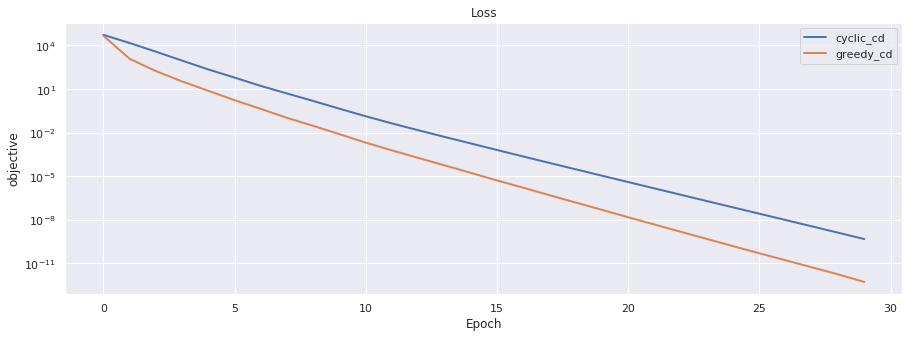

In [9]:
monitors = [cyclic_cd, greedy_cd]
solvers = ['cyclic_cd', 'greedy_cd']
plot_epochs(monitors, solvers)

<div class="alert alert-info" role="alert">
<center>
<h4>Interprétation:</h4>
<br>
    
First, both algorithms are optimizing over a single coordinate while holding others fixed.

we can see from the graph that the greedy algorithm is faster in terms of convergence than the cyclic algorithm.
this result is predictable since in each iteration, the greedy algorithm takes the direction having the highest gradient, ie the direction that minimizes the function the most.

On the other hand, for the cyclic algorithm,
the choice of the coordinate is taken in a cyclic manner which does not correspond to the optimal choice of the minimization direction.

In terms of execution time and calculation cost, we can see that the greedy algorithm requires a lot of memory and it takes a lot of time to find the optimal direction since at each iteration it must recompute all the components of the gradient.
</center>
</div>

<div class="alert alert-success" role="alert">
<center>
<h5> Question 3: could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.

<div class="alert alert-info" role="alert">
<center>
<h4>
    a) Could you use greedy CD for unregularized logistic regression?</h4></center>
When we use the greedy CD for unregularized logistic regression, our function $f(w)=\frac 12 \Vert Aw - b \Vert ^2 $ that we want to minimize might not be strictly convex as its hessian matrix $\nabla^2f=A^T.A$ is not necessarily definite positive. In this case, the greedy CD algorithm might converge to a local minimum instead of the global minimum
 

<div class="alert alert-info" role="alert">
<center>
<h4>b) For OLS, but with 100,000 features:</h4>

It is not appropriate to use the greedy algorithm in this case because our data has 100,000 features. this will necessarily have a huge computing cost and will require a large memory capacity.
In fact, the need for a large memory capacity is due in part to the calculation of the Gram $A^TA$ matrix whose size is $\mathbb{R}^{100000 x 100000}$.

Moreover, the high cost of the computation is due to the fact that for each iteration, we have to compute all compostantes of the gradient of f (we must recompute $\partial_i f(w)\ \ \forall i)$ .
</center>
</div>

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success" role="alert">
    <center><h5>Question 1)</h5></center> 
        <br>Show that:
        <h5>
$$ \lambda \geq \lambda_{max} \implies \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert_1 (w_1)  \times \dots \times \partial \vert \cdot \vert_1 (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert_1 (w_1) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

<div class="alert alert-info" role="alert">
<center>
<h4>
<B>Answer :</B></h4

We denote f by $f(w)=\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )$
Then
$\partial f(w)= \sum_{i=1}^{n} \frac{x_i^T y}{ 1 + e^{- y_i w^\top x_i}}$
<br>
We are trying to solve 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1=\mathrm{arg \, min} f(w)  + \lambda \Vert w \Vert_1=\mathrm{arg \, min} L(w)$$
<br>
We have 
<br>
$\begin{align*} 
\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty} := \frac 12\max_i (\vert x_i^T y\vert)\leq \lambda &\iff \forall i \in \{1..n\} \frac 12(\vert x_i^T y\vert)\leq \lambda  \\
&\iff  \forall i \in \{1..n\} \frac 12 x_i^T y \in \lambda * [-1,1] \\
&\iff  \frac 12 X^\top y \in \lambda*B_{\infty} \ where B_{\infty}=[-1,1]^p  \\
&\iff \frac 12 \sum_{i=1}^nx_i^T y \in \lambda*B_{\infty} \  or \frac12=\frac{x_i^T y}{ 1 + e^{- y_i 0^\top x_i}}\\ 
&\iff \sum_{i=1}^{n} \frac{x_i^T y}{ 1 + e^{- y_i 0^\top x_i}}  \in \lambda*B_{\infty}=\lambda  \partial \Vert . \Vert (0)  \\ 
&\iff  -\partial f(0) \in \lambda  \partial \Vert . \Vert (0)  \\
&\iff  0 \in \partial f(0) + \lambda  \partial \Vert . \Vert (0)  \\
&\iff  0 \in (\partial f + \lambda  \partial \Vert . \Vert) (0)= \partial L(0)  \\
&\iff  0 \in  \arg\min  L(w)  (using \  fermat's \  rules)\\
&\iff  0 \in   \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1\\
&\iff \hat w = 0
\end{align*}$
    </center>
    </div>

<div class="alert alert-success" role="alert">
<center>
    <h5>Question2) </h5></center>
    <br>
    <h5>Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

<div class="alert alert-info" role="alert">
<center>
<h4>
**Answer :**</h4>

Let's assume $f(x)= \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} ) $ 
<br>we compute the $j^{th}$ coordinate of the diagonal of the hessian matrix : $$\frac{\partial^2f(x)}{\partial\omega_j^2}=\sum_{i=1}^{n} \frac{y_i^2 x_{i,j} x_{i,j} e^{y_ix_i^T\omega_T}}{(1+e^{y_ix_i^T\omega_T})^2}=\sum_{i=1}^{n} \frac{x_{i,j}^2 e^{y_ix_i^T\omega_T}}{(1+e^{y_ix_i^T\omega_T})^2}$$

So:  $\Vert\frac{\partial^2f(x)}{\partial\omega_j^2}\Vert_2 = \sum_{i=1}^{n} \frac{e^{y_ix_i^T\omega_T}}{(1+e^{y_ix_i^T\omega_T})^2}x_{ij}^2$ 
 
 We know that $\frac{e^\alpha}{(1+e^\alpha)^2}\leq \frac{1}{4}$ $ \forall \alpha \in \mathbb{R}$ then :
 
 $\Vert\frac{\partial^2f(x)}{\partial\omega_j^2}\Vert_2 \leq \frac{1}{4}\sum_{i=1}^{n} x_{ij}^2=\frac{1}{4}X_j^TX_j$ where $X_j$ is the $j^{th}$ column of X .
 
Finally : 
$$ \Vert\frac{\partial^2f(x)}{\partial\omega_j^2}\Vert_2 \leq \frac{\Vert X_j\Vert_2}{4} $$ 

**Conclusion :** the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$ 
    </center>
    </div>
 

You are now ready to code cyclic proximal coordinate descent for sparse Logistic regression:

<div class="alert alert-success" role="alert">
<center>
    <h5>Question Bonus: show that is possible, when the current iterate is w, to use the better Lipschitz constant 
    $$\sum_i  \frac{X_{i, j}^2}{(1 + \mathrm{e}^{-y_i X_{i, j} w_j)^2}}$$
    
(why is it better?)
</h5>
</center>
</div>

<div class="alert alert-info" role="alert">
<center>
    <h4><B>Answer</B></h4>

<br>
First, it's clear that $L_j = \sum_{i=1}^n  \frac{X_{i, j}^2 \mathrm{e}^{(Xw)_i}}{(1 +
\mathrm{e}^{(Xw)_i})^2}\leq \Vert X_j \Vert^2 / 4 \ \  $(1). In fact, as we have show before:
$$ \frac{e^x}{(1+e^x)^2} \leq \frac14 \ and \  \Vert X_j \Vert^2=\sum_{i=1}^n  X_{i, j}^2 $$
Now, we'll just prove that $L_j = \sum_{i=1}^n  \frac{X_{i, j}^2 \mathrm{e}^{(Xw)_i}}{(1 +
\mathrm{e}^{(Xw)_i})^2} $ is a lipschitz constant 

We have   $ \frac{\partial ^2 f}{(\partial w_i)^2} = \sum_{i=1}^{n} \frac{y_i^2 X_{ij}^2 e^{ y_i w^\top x_i}}{( 1 + e^{ y_i w^\top x_i} )^2} $ .

We denote h by  $ h(x) = \frac{e^x}{(1+e^x)^2} $ 
<br>
$h(-x)= \frac{e^{-x}}{(1+e^{-x})^2}= \frac{e^{-x}}{e^{-2x}(1+e^x)^2}=\frac{e^x}{(1+e^x)^2}=h(x)$
<br>
then h is pair and since $y_i \in \{-1,1\}$ 
<br> therefore $h(y_i w^\top x_i)=h( w^\top x_i) \forall i $

We have $ \frac{\partial ^2 f}{(\partial w_j)^2}= \sum_{i=1}^n  X_{i, j}^2 h(y_i w^\top x_i)= \sum_{i=1}^n  X_{i, j}^2 h(w^\top x_i)\leq  \sum_{i=1}^{n} \frac{X_{ij}^2 e^{ y_i w^\top x_i}}{( 1 + e^{ y_i w^\top x_i} )^2} =L_J $. 
<br> 
  Then $L_j$ is a lipschitz constant   $\ \ \ \ \ \ $(2).
  <br>
  Acoording to (1) and (2)  $$L_j = \sum_{i=1}^n  \frac{X_{i, j}^2 \mathrm{e}^{(Xw)_i}}{(1 +
\mathrm{e}^{(Xw)_i})^2}$$  is a better Lipschitz constant than $ \Vert X_j \Vert^2 / 4 \ \  $
    </center>
    </div>

Implement it in the code with a `better_lc` parameter, and compare.

In [10]:

X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord=np.inf) / 2.
lamb = lambda_max / 10.
# much easier to parametrize lambda as a function of lambda_max than
# to take random values like 0.1 in previous Labs

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.maximum(0., np.abs(x) - u)

def cd_logreg(X, y, lamb, n_iter, better_lc=False, save_w=False):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)

    # TODO
    if better_lc:
        lips_const = [np.sum([X[i, j]**2*np.exp(np.abs(Xw[i]))/(sigmoid(np.abs(Xw[i])))
                              ** 2 for i in range(n_samples)]) for j in range(n_features)]

    else:
        lips_const = np.linalg.norm(X, axis=0)**2/4.
    # END TODO

    all_objs = np.zeros(n_iter)
    
    w_save=np.array([])
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]

            # TODO
            grad_j = (-1)*np.sum([y[i]*X[i, j]*sigmoid(-y[i]*Xw[i])
                                  for i in range(n_samples)])
            w[j] = np.sign(w[j]-grad_j/lips_const[j]) * \
                soft_thresh(w[j]-grad_j/lips_const[j], lamb/lips_const[j])

            if old_w_j != w[j]:
                Xw += X[:, j]*(w[j]-old_w_j)
            # END TODO

        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + \
            lamb * norm(w, ord=1)
        if(save_w==True):
            w_save=np.append(w_save,w)
    
    
    if (save_w==True):
        w_save=np.reshape(w_save,(n_iter,n_features))
        return w, all_objs,w_save
    else:        
        return w, all_objs

In [11]:
_, all_better_lc,w_saved_better_lc = cd_logreg(X, y, lamb, 20, better_lc=True,save_w=True)

In [12]:
_,all_lc,w_saved_lc=cd_logreg(X, y, lamb, 20, better_lc=False,save_w=True)

In [13]:
def find_min(X_,y_,lamb_):

    def loss_log_reg_(w_, X_, y_,lamb_):
        return np.sum([np.log(1+np.exp(-y_[i]*X_[i].dot(w_)))for i in range(X_.shape[0])])+lamb_*np.linalg.norm(w_,ord=1)


    def grad_log_reg_(w_, X_, y_,lamb_):
        return np.sum([-y_[i]*X_[i]*sigmoid(-y_[i]*(X_[i].dot(w_))) for i in range(X_.shape[0])], axis=0)+lamb_*np.sign(w_)

    x_init_ = np.zeros(X_.shape[1])
    x_min_log_reg_, f_min_log_reg_, _ = fmin_l_bfgs_b(
        loss_log_reg_, x_init_, grad_log_reg_, args=(X_, y_,lamb_), pgtol=1e-30, factr=1e-30)
    return x_min_log_reg_,f_min_log_reg_

In [14]:
x_min_log_reg, f_min_log_reg = find_min(X, y, lamb)

In [15]:
def plot_comparison(obj_better_ls,obj_lc,w_better_lc,w_lc,f_min_,x_min_, n_iter=3000):
    plt.figure(figsize=(15, 5))

    diff_obj = obj_lc - f_min_
    diff_obj_better=obj_better_ls-f_min_
    
    error=np.array([np.linalg.norm(w_lc[t]-x_min_) for t in range(w_lc.shape[0])])
    error_better=np.array([np.linalg.norm(w_better_lc[t]-x_min_) for t in range(w_better_lc.shape[0])])
    
    plt.subplot(1,2,1)
    plt.semilogy(diff_obj, lw=2,label='loss without better_lc')
    plt.semilogy(diff_obj_better, lw=2,label='loss with better_lc')
    
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("objective")

    plt.legend()
    
    plt.subplot(1,2,2)
    
    plt.semilogy(error, lw=2,label='error without better_lc')
    plt.semilogy(error_better, lw=2,label='error with better_lc')
    
    plt.title("error")
    plt.xlabel("Epoch")
    plt.ylabel("objective")
    plt.legend()


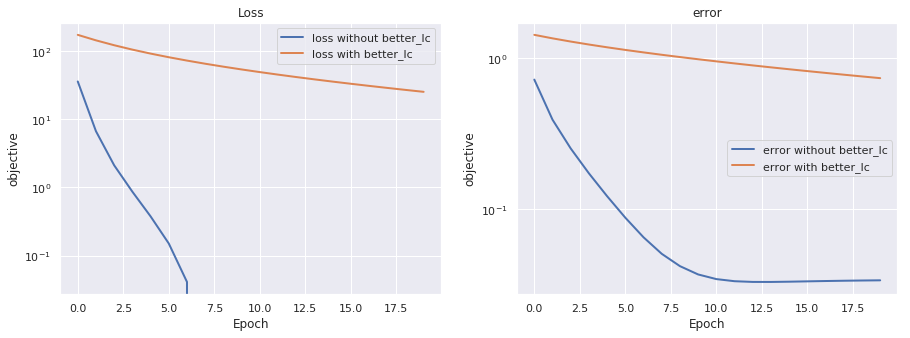

In [16]:
plot_comparison(all_better_lc,all_lc,w_saved_better_lc,w_saved_lc,f_min_log_reg,x_min_log_reg)

<div class="alert alert-info" role="alert">
<center>
    <h4>Comparaison manquante </h4>
    </center>
    </div>

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

You can download the file here: http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv, and you should place it in the same folder as the current notebook.

In [17]:
from numpy import genfromtxt
y = 2 * (genfromtxt('leukemia_big.csv',
                    delimiter=',', dtype=str)[0] == 'ALL') - 1
X = genfromtxt('leukemia_big.csv', delimiter=',')[1:].T


In [18]:
lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)/2.
lambd = lambda_max_lasso / 10

Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

<div class="alert alert-success" role="alert">
<center>
<h5>Question 1 : Code a simple proximal gradient solver for the Lasso

In [19]:
def prox_lasso(x, lamb):
    return np.sign(x)*np.maximum(0, np.abs(x)-lamb)


def lasso(x, lamb):
    return lamb*np.linalg.norm(x, ord=1)


def loss_log_reg(w, X, y):
    return np.sum([np.log(1+np.exp(-y[i]*X[i].dot(w)))for i in range(X.shape[0])])


def grad_log_reg(w, X, y):

    return np.sum([-y[i]*X[i]*sigmoid(-y[i]*(X[i].dot(w))) for i in range(X.shape[0])], axis=0)


def lip_log_reg(X):
    return np.linalg.norm(X)/4.*X.shape[0]

In [22]:
def ista(w0, loss, grad_loss, pen, prox_pen, step, s=lambd, n_iter=50):
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = X.shape

    objectives = []
    obj = loss(w, X, y)+pen(w, s)
    objectives.append(obj)

    for t in range(n_iter+1):
        w = prox_pen(w-(1./step)*grad_loss(w, X, y), float(s)/step)

        obj = loss(w, X, y)+pen(w, s)
        objectives.append(obj)
    return w, objectives

<div class="alert alert-success" role="alert">
<center>
<h5>Question 2 : Compare them on this dataset

In [30]:
w0 = np.zeros(X.shape[1])
w, objectiv = ista(w0, loss=loss_log_reg, grad_loss=grad_log_reg, n_iter=100,
                   pen=lasso, prox_pen=prox_lasso, s=lambd/2, step=lip_log_reg(X))

In [28]:
_,all_,w_saved_value = cd_logreg(X, y, lambd, 100, better_lc=True,save_w=True)

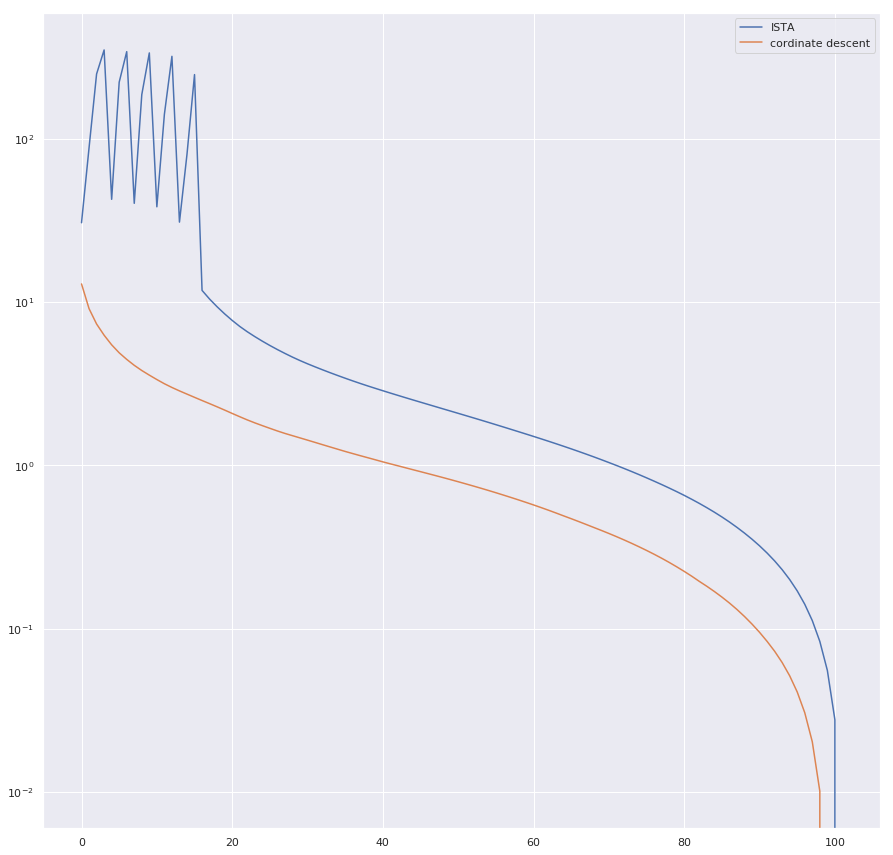

In [34]:
plt.figure(figsize=(15,15))
plt.semilogy(objectiv-objectiv[-1], label="ISTA")
plt.semilogy(all_-all_[-1], label="cordinate descent")
plt.legend()

<div class="alert alert-info" role="alert">
<center>
    <h4>Interpretation manquante </h4>
    </center>
    </div>